In [1]:
import sys
print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(["/home/mathia/PycharmProjects/neslearn-git/",
                 "/home/peer/PycharmProjects/neslearng/",
                 "/home/mathia/PycharmProjects/neslearn-git/extern/nes-async-rl/"])

Python 3.4.2 (default, Oct  8 2014, 10:45:20) 
[GCC 4.9.1] on linux


In [2]:
%matplotlib inline

In [3]:
import dqn_head
import nes as nes_ale_interface
from dqn_phi import dqn_phi
from hsa.machine_constants import mario_rom_location
import numpy as np
import matplotlib.pyplot as plt
import chainer
from hsa.visualization.parse_fm2 import parse_fm2
from hsa.nes_python_input import py_to_nes_wrapper
import scipy.misc
from chainer import serializers
from a3c_nes import A3CLSTM
import imageio
import scipy.misc
from sklearn.neighbors import KNeighborsClassifier
import random


In [4]:
from extern.fceux_learningenv.nes_python_interface.nes_python_interface import NESInterface, nes_lib
from hsa.machine_constants import mario_rom_location

In [5]:
def preprocess_rgb(rgb_img):
    assert rgb_img.shape == (224, 256, 3)
    # RGB -> Luminance
    img = rgb_img[:, :, 0] * 0.2126 + rgb_img[:, :, 1] * \
        0.0722 + rgb_img[:, :, 2] * 0.7152
    img = img.astype(np.uint8)
    img = scipy.misc.imresize(img, (84, 84))
    assert img.shape == (84, 84)
    return img

In [6]:
movie_inputs = []
def iterate_movie(movie_path):
    nes = NESInterface(mario_rom_location,eb_compatible=True)
    with open(movie_path) as movie_file:
        for i, combi in enumerate(parse_fm2(movie_file)):
            reward = nes.act(py_to_nes_wrapper(combi))
            if i % 4 == 0:
                movie_inputs.append(py_to_nes_wrapper(combi))
                yield preprocess_rgb(nes.getScreenRGB())
            nes.render()

In [7]:
movie_screens_iter= iterate_movie("/home/mathia/PycharmProjects/neslearn-git/movies/5_1-1_without-shortcut.fm2")
movie_screens = list(movie_screens_iter)

In [8]:
# Maybe nesseary to insert prepending frames?
movie_screens.insert(0,np.zeros_like(movie_screens[0]))
movie_screens.insert(1,np.zeros_like(movie_screens[0]))
movie_screens.insert(2,np.zeros_like(movie_screens[0]))

In [9]:
len(movie_inputs)

602

In [10]:
len(movie_screens)

605

In [11]:
for i in range(len(movie_screens)-3):
     dqn_phi(movie_screens[i:i+4])

In [12]:
nn = A3CLSTM(n_actions=15)
serializers.load_hdf5("/home/mathia/checkpoints/nes_a3c_scaled_finer_main_reward_1/16000000_finish.h5",nn)

In [13]:
def screens_to_embeding(screens):
    """screens should be len=4"""
    s = chainer.Variable(np.expand_dims(dqn_phi(screens), 0))
    return nn.head(s)

In [14]:
screens_to_embeding(movie_screens[4:8]).data.shape

(1, 256)

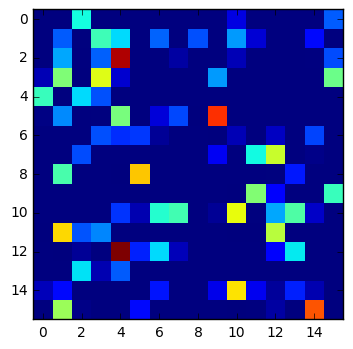

In [17]:
plt.imshow(screens_to_embeding(movie_screens[4:8]).data.reshape((16,16)),interpolation="none")

In [18]:
movie_writer = imageio.get_writer("embedding_5_1-1_without-shortcut.mp4", fps=60/4, quality=9)
for i in range(len(movie_screens)-3):
    embedding = screens_to_embeding(movie_screens[i:i+4]).data.reshape((16,16))
    video_frame = scipy.misc.imresize(embedding, (128,128),interp="nearest")
    movie_writer.append_data(video_frame)
movie_writer.close()

In [15]:
movie_embeddings= np.array([screens_to_embeding(movie_screens[i:i+4]).data.reshape(256) for i in range(len(movie_screens)-3)])

In [16]:
movie_embeddings.shape

(602, 256)

In [17]:
len(movie_embeddings)

602

In [18]:
len(movie_inputs)

602

In [19]:
np.array(movie_inputs[0:40])

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         8,   0,   8,   8,   8,   0,   0,   0,   0,   0,   4,   0,   0,
         0,   0,   0, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130])

## Train KNN form embeding to input

In [16]:
knn = KNeighborsClassifier(n_neighbors=20)

In [17]:
knn.fit(movie_embeddings,movie_inputs)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

## other things

In [20]:
def play_clone_fine(how_long,epsilon_greedy):
    nes = NESInterface(mario_rom_location,eb_compatible=True)
    nes.reset_game()
    action = 0
    reward_sum = 0
    for i in range(how_long):
        screens= []
        if nes.lives() < 1:
            nes.reset_game()
        if random.random()<0.2 and epsilon_greedy:
            action = random.choice(nes.getMinimalActionSet())
        for i in range(4):
            a_reward = nes.act(action)
            reward_sum += a_reward
            screens.append(preprocess_rgb(nes.getScreenRGB()))
        action = knn.predict(screens_to_embeding(screens).data)
    return reward_sum
        

In [21]:
play_clone_fine(1000,True)

5935

In [ ]:
nes = NESInterface(mario_rom_location,eb_compatible=True)

In [1]:

screens= []
reward_sum = 0
for i in range(4):
    a_reward = nes.act(0)
    reward_sum += a_reward
    screens.append(preprocess_rgb(nes.getScreenRGB()))
action = knn.predict(screens_to_embeding(screens))

NameError: name 'NESInterface' is not defined

In [ ]:
del nes

## using the other interface unsuccessfully 

In [22]:
def play_clone(how_long):
    # nes = NESInterface(mario_rom_location,eb_compatible=True)
    env = nes_ale_interface.NES(mario_rom_location) 
    for i in range(how_long):
        embedding = screens_to_embeding(env.state)
        action = knn.predict(embedding.data)
        reward = env.receive_action(action)
        yield reward


In [23]:
sum(play_clone(100))

IndexError: index 130 is out of bounds for axis 1 with size 15

In [41]:
env = nes_ale_interface.NES(mario_rom_location) 
embedding = screens_to_embeding(env.state)


In [43]:
embedding.data

array([[  6.34270430e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.49668913e+01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.50532722e+00,   0.00000000e+00,   1.97391939e+00,
          0.00000000e+00,   3.81560946e+00,   5.94799471e+00,
          0.00000000e+00,   0.00000000e+00,   7.26984024e-01,
          8.60673666e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   4.17941427e+00,   4.30993414e+00,
          2.20376626e-03,   0.00000000e+00,   0.00000000e+00,
          2.58206520e+01,   0.00000000e+00,   0.00000000e+00,
          5.58074284e+00,   5.84123135e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.84434903e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.80977497e+01,
        

In [ ]:
action = knn.predict(embedding)
reward = env.receive_action(action)